#**Mount google drive with the .csv data**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize

from numpy import log, exp
import numpy as np

import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels as sm
import pymc3 as pm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Most of the work done here is reference from**: <br>
https://www.analyticsvidhya.com/blog/2018/07/introductory-guide-maximum-likelihood-estimation-case-study-r/
<br> The blog has same type of data, Poisson Distribion based on real data:<br>

# **Bike Sharing**
We will be using data from the BikeSharing hour.csv only.
It contains more samples as it has the finer details of the number of bike rental per hour for the period of 2 years.

In [0]:
#Path name to the data.csv
filepath = "/content/gdrive/My Drive/Colab Notebooks/CS5340/hour.csv"
hour = pd.read_csv(filepath)

In [0]:
hour

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


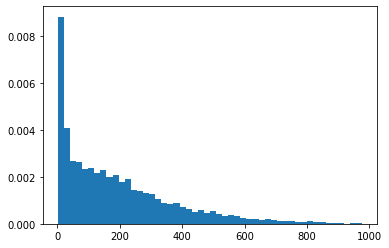

In [0]:
#check the distribution of the data.
plt.hist(hour.cnt, bins=50, density=True)
plt.show()

Text(0.5, 0, 'hours for 2 years')

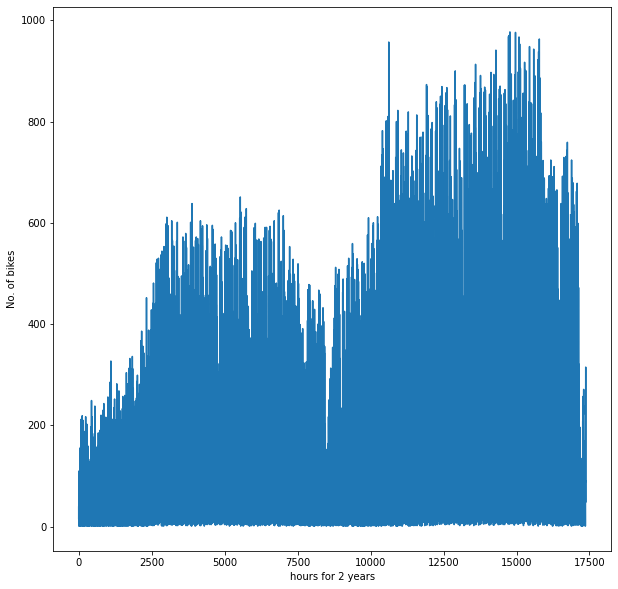

In [0]:
#Plot the number of rented bikes between this 2 years. Overall is still increasing
fig, axes = plt.subplots(1, 1, sharex=False, figsize=(10,10))

axes.plot(hour.instant, hour.cnt)
axes.set_ylabel('No. of bikes')
axes.set_xlabel('hours for 2 years')

In [0]:
#Split data here
train, test = train_test_split(hour, test_size=0.2, random_state=42)

#sort them in ascending order to maintain the temporal order
train = train.sort_index()
test = test.sort_index()

print(train.shape)
print(test.shape)

(13903, 17)
(3476, 17)


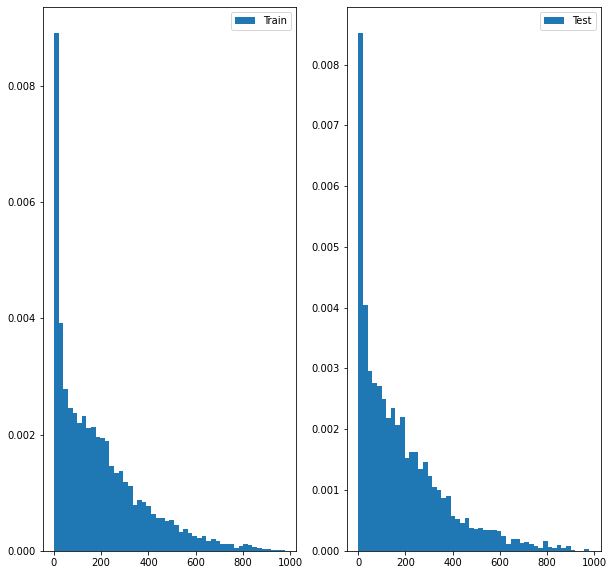

In [0]:
#Check the distribution of the train and test set
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,10))
axes[0].hist(train.cnt, bins=50, density=True, label = 'Train')
axes[1].hist(test.cnt, bins=50, density=True, label = 'Test')
axes[0].legend()
axes[1].legend()

##**MLE**

Data seems to have a Poisson distribution. As it is base on the event of the number of bike rental per hour for the period of 2 years. To keep things simple we will be using a linear model for the prediction. We will be using the Poisson regression model
https://en.wikipedia.org/wiki/Poisson_regression<br>
$$
\mu = exp(x\theta)
$$
We shall use the Poisson Distribution to model the likelyhood. The Poisson distribution is given by https://en.wikipedia.org/wiki/Poisson_distribution:
$$
Pr(X=x|\mu) = Pois(\mu) = \frac{\mu^{x} e^{-\mu}}{x!}
$$
Estimation of the parameter theta by using loglikely hood (MLE), 
$$
LL(\theta) = \sum \big(xlog(\mu) - \mu\big)
$$

Since the data consists of some temporal variables like year, mnth, weekday and hr. We will only use them in our model <br>
$$
\mu =  exp(year*\theta_0+ mnth*\theta_1 + weekday*\theta_2 + hr*\theta_3)
$$

In [0]:
train.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000
mean,8697.040135,2.509243,0.502050,6.552974,11.557146,0.028699,2.998202,0.679566,1.426023,0.497396,0.476183,0.627011,0.189822,36.002374,154.574696,190.577070
std,5024.565656,1.106817,0.500014,3.436925,6.911927,0.166965,2.011350,0.466660,0.638842,0.193017,0.172308,0.192801,0.122293,49.636195,152.035090,182.220507
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4355.500000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,4.000000,34.000000,39.000000
50%,8677.000000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.164200,17.000000,116.000000,143.000000
75%,13077.500000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,49.000000,221.500000,282.000000
max,17379.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,885.000000,976.000000


In [0]:
# functions for the negative log likely hood and Prediction.
def negloglike(theta, cnt, year, mth, day, hr):
    mu = exp(theta[0]+theta[1]*year + theta[2]*mth+ theta[3]*day+ theta[4]*hr)
    nll= -sum(cnt*(log(mu)) - mu)
    return nll

def predict_cnt(theta, year, mth, day, hr):
    estimated_cnt = exp(theta[0] + theta[1]*year+ theta[2]*mth+ theta[3]*day+theta[4]*hr)
    return estimated_cnt


In [0]:
#Set a high number to allow the optimizer to minimize successfully
maxNumberIters =  train.cnt.count()*1000
print(maxNumberIters)

#Using an off-the-shelve optimizer similar to those used in lecture
params_MLE = optimize.minimize(negloglike,np.array([0,0,0,0,0]), args=(train.cnt,train.yr,train.mnth,train.weekday, train.hr), options={'maxiter': maxNumberIters}, method='Nelder-Mead')
print(params_MLE)

13903000
 final_simplex: (array([[3.95682943, 0.5059893 , 0.03627459, 0.01256711, 0.05629742],
       [3.95683168, 0.50599079, 0.0362753 , 0.01256724, 0.05629716],
       [3.95681183, 0.50599835, 0.03627789, 0.01256457, 0.05629716],
       [3.95682453, 0.50597621, 0.03627672, 0.01256849, 0.0562974 ],
       [3.95681347, 0.5059866 , 0.03627526, 0.01257172, 0.05629753],
       [3.95681696, 0.50598882, 0.03627691, 0.01256419, 0.05629793]]), array([-11553173.09785971, -11553173.09785843, -11553173.09782322,
       -11553173.09779629, -11553173.09777839, -11553173.0977605 ]))
           fun: -11553173.097859707
       message: 'Optimization terminated successfully.'
          nfev: 1160
           nit: 723
        status: 0
       success: True
             x: array([3.95682943, 0.5059893 , 0.03627459, 0.01256711, 0.05629742])


In [0]:
predictionMLE_cnt = predict_cnt(params_MLE.x, test.yr,test.mnth, test.weekday, test.hr)

print(predictionMLE_cnt)

3         69.227553
5         77.477981
8         91.733352
14       128.595333
19       170.401532
            ...    
17354    489.289531
17355    135.731808
17367    266.733474
17375    418.480070
17377    468.353849
Length: 3476, dtype: float64


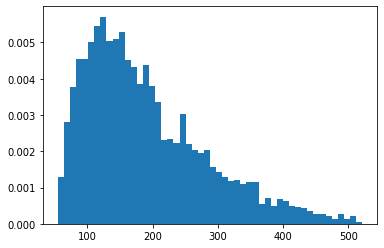

In [0]:
#Prediction looks like the gamma distribution
plt.hist(predictionMLE_cnt, bins=50, density=True)
plt.show()

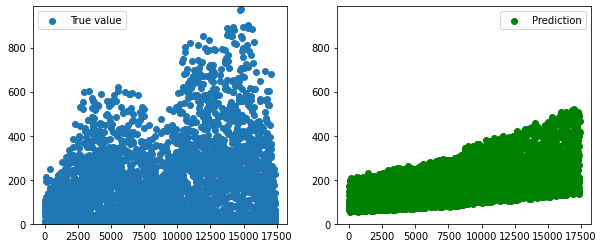

In [0]:
#Compare the action data and predictions side by side
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(test.instant, test.cnt,label="True value")
ax[0].set_ylim([0,test.cnt.max()+10])
ax[1].scatter(test.instant,predictionMLE_cnt,color='g', lw=1,label="Prediction")
ax[1].set_ylim([0,test.cnt.max()+10])
ax[0].legend()
ax[1].legend()

## **MAP**

For MAP, we will need to calculate the posterior. We will be using gamma as the congugate prior for the Poisson distribution.
Hence, the posterior will also be a Gamma distribution
$$
Pr(\mu|X) = Pr(X|\mu) Pr(\mu) = Pois(\mu)*Gamma(\alpha,\beta) =\frac{\mu^{x} e^{-\mu}}{x!} \frac{\beta^{\alpha}\mu^{\alpha-1}e^{-\beta \mu}}{\Gamma(\alpha)}
$$
$$
                                    \propto \mu^{x} e^{-\mu} \mu^{\alpha-1}e^{-\beta \mu}\\
                                    \propto \mu^{x+\alpha - 1} e^{-\mu(\beta+1)}
$$
The updated gamma parameters are as:
$$
 Gamma(\alpha + x, \beta - \mu)
$$
Now maximize the log MAP:
$$
LL(\theta) = \sum \big((x+\alpha-1).log(\mu) -\mu \beta - \mu \big)
$$

In [0]:
# using an optimizer
def neglogpost(theta,cnt, year, mth, day, hr,a,b):
    mu = exp(theta[0]+theta[1]*year + theta[2]*mth+ theta[3]*day+ theta[4]*hr)
    
    nlpost= -sum((cnt+a-1)*log(mu) - mu*b -mu)
    return nlpost


The alpha and beta parameters of the gamma distribution is calculated by fitting a gamma distribution over the training data. https://en.wikipedia.org/wiki/Gamma_distribution

0.830845944586797 0 229.3771437880304


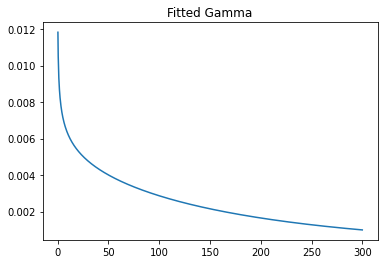

In [0]:
shape, loc, scale = stats.gamma.fit(train.cnt, floc=0)
print(shape, loc, scale)
x = np.linspace(0,300,1000)
y = stats.gamma.pdf(x, shape, loc, scale)
plt.title('Fitted Gamma')
plt.plot(x, y)
plt.show()

In [0]:
alphag = shape
betag = 1/scale
print(alphag)
print(betag)

0.830845944586797
0.004359632278463235


In [0]:
params_MAP = optimize.minimize(neglogpost,np.array([0,0,0,0,0]), args=(train.cnt, train.yr, train.mnth, train.weekday, train.hr, alphag,betag),options={'maxiter': maxNumberIters}, method='Nelder-Mead')

print(params_MAP)

 final_simplex: (array([[3.95028715, 0.50645694, 0.03630792, 0.01257973, 0.05635015],
       [3.95030265, 0.5064534 , 0.03630931, 0.01257746, 0.05634838],
       [3.95026444, 0.5064503 , 0.03631064, 0.01257935, 0.05634987],
       [3.95028131, 0.50644549, 0.03631098, 0.01257746, 0.05634975],
       [3.95028927, 0.50645898, 0.03630977, 0.01257364, 0.05634964],
       [3.95029965, 0.50643458, 0.03630793, 0.01257819, 0.05634997]]), array([-11529577.8136692 , -11529577.81365582, -11529577.81364848,
       -11529577.81363893, -11529577.813604  , -11529577.81359212]))
           fun: -11529577.813669205
       message: 'Optimization terminated successfully.'
          nfev: 1344
           nit: 830
        status: 0
       success: True
             x: array([3.95028715, 0.50645694, 0.03630792, 0.01257973, 0.05635015])


In [0]:
predictionMAP_cnt = predict_cnt(params_MAP.x, test.yr,test.mnth, test.weekday, test.hr)

print(predictionMAP_cnt)

3         68.794505
5         77.001444
8         91.183560
14       127.865064
19       169.478533
            ...    
17354    487.111285
17355    134.965460
17367    265.395373
17375    416.556408
17377    466.250100
Length: 3476, dtype: float64


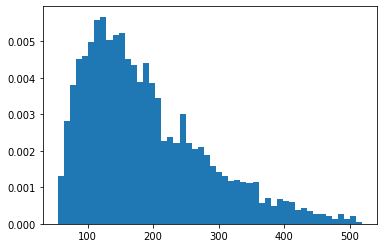

In [0]:
#Prediction looks like the gamma distribution too
plt.hist(predictionMAP_cnt, bins=50, density=True)
plt.show()

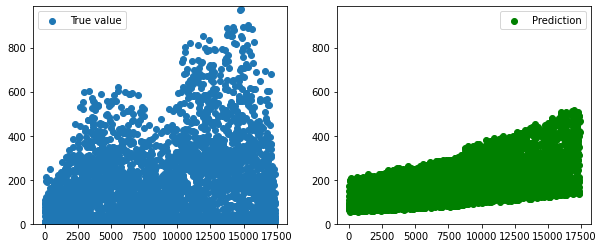

In [0]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(test.instant, test.cnt,label="True value")
ax[0].set_ylim([0,test.cnt.max()+10])
ax[1].scatter(test.instant,predictionMAP_cnt,color='g', lw=1,label="Prediction")
ax[1].set_ylim([0,test.cnt.max()+10])
ax[0].legend()
ax[1].legend()

## **Compare the MLE and MAP Predictions**

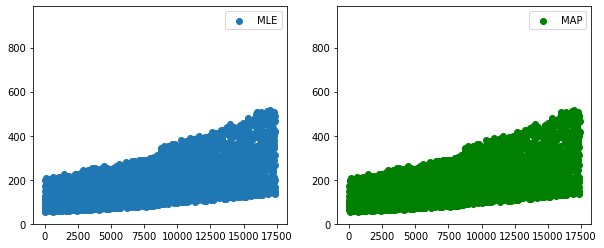

In [0]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(test.instant, predictionMAP_cnt, lw=1,label="MLE")
ax[0].set_ylim([0,test.cnt.max()+10])
ax[1].scatter(test.instant,predictionMAP_cnt,color='g', lw=1,label="MAP")
ax[1].set_ylim([0,test.cnt.max()+10])
ax[0].legend()
ax[1].legend()

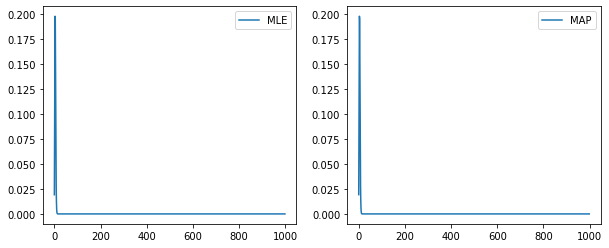

In [0]:
z = np.arange(0, 1000)
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(z, stats.poisson.pmf(z, params_MLE.x[0]), label="MLE")
ax[1].plot(z, stats.poisson.pmf(z, params_MAP.x[0]), label="MAP")
ax[0].legend()
ax[1].legend()

In [0]:
mu_mle = params_MLE
mu_map = params_MAP

y = np.arange(0,  200)

print("MLE MSE error: ",mean_squared_error(test.cnt, predictionMLE_cnt))
print("MAP MSE error: ",mean_squared_error(test.cnt, predictionMAP_cnt))



MLE MSE error:  26717.269774374276
MAP MSE error:  26695.290537743673


We could see that the MAP predictions are a bit better than the MLE predictions. As there are quite a large number of samples used and the prior we chose helps the data to fit. The MAP predictions are quite similar to the MLE predictions too due to the large number of samples available<br>

(*Ignore the large error as we used a simple linear model for a complex dataset, the key point we are studying is the difference between the MLE and MAP predictions*)
